## 0. Execute Once - Load Dataset From Kaggle

### Set up the notebook
- **Create new API Token** under Kaggle profile
- Upload downloaded kaggle.json file to the designated folder on Google Drive

In [1]:
# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Download Dataset

Go to Kaggle datasets Dashboard and click on `Copy API Command`.

Note: The dataset is downloaded as a zip file. We use a keyword `--unzip` used to instantly unzip the file after download and delete the zip file.

Config Kaggle

In [2]:
# set the Kaggle configuration path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/deep_learning"

In [3]:
# change the working directory
%cd /content/gdrive/MyDrive/deep_learning/data

/content/gdrive/MyDrive/deep_learning/data


In [4]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

tomato-disease-multiple-sources.zip: Skipping, found more recently modified local copy (use --force to force download)


### Copy Raw Data Files From Google Drive To Local Colab Session to Avoid Disrupt Connections

In [5]:
# create 'data' folder in local VM
#!rm /content/data -r
!mkdir /content/data

In [6]:
# copy .zip and unzip in local VM to avoid exceed Google Drive daily limits
!cp -r /content/gdrive/MyDrive/deep_learning/data/tomato-disease-multiple-sources.zip /content/data

In [7]:
# change the working directory to local VM
%cd /content/data

/content/data


In [8]:
# unzip using python library
import zipfile

with zipfile.ZipFile('tomato-disease-multiple-sources.zip','r') as zip_ref:
  zip_ref.extractall('./')

In [9]:
# check the file using 'ls' command
%ls

tomato-disease-multiple-sources.zip  train/  valid/


In [10]:
# audit: make sure we have 25,851 images in train and 6,684 images in valid
train_len, test_len = 0, 0
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))

print("{} images in training set".format(train_len))
print("{} images in test set.".format(test_len))
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

25851 images in training set
6684 images in test set.


## 1. Set-up

### Import Libraries

In [11]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# others
import os, gc, time, pathlib, datetime
import tqdm
import imghdr

# set up random seed
import random
seed = 24
tf.random.set_seed(seed)

### Environmental Variables

In [12]:
# environmental variables
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

CLASSES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASSES)
TIMESTAMP = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [13]:
# audit - check number of classes
print(CLASSES)
print('{} classes of images'.format(NUM_CLASSES))

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
11 classes of images


In [14]:
# audit - check number of raw images
train_len, test_len = 0, 0

for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))

print(train_len); print(test_len)
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

25851
6684


## 2. Data Cleaning

TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.

*Reference*:
- [Unknown image file format. One of JPEG, PNG, GIF, BMP required](https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required)

In [15]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [16]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)
          
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)

  return bad_images

In [17]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.54 µs
-------------------- check training set image quality. --------------------
/content/data/train/healthy/edible-tomato-leaves.jpg is a webp, not accepted by TensorFlow
/content/data/train/healthy/tomato-leaf-isolated-on-white-260nw-580281301.jpg is not an image
/content/data/train/healthy/branch-tomato-leaves-iaolsted-on-260nw-1025727106.jpg is not an image
/content/data/train/Septoria_leaf_spot/SS_ (51).jpg is not an image
/content/data/train/Leaf_Mold/BM_(7).jpg is not an image
/content/data/train/Leaf_Mold/607-155-1.jpg is not an image
/content/data/train/Leaf_Mold/BM_(98).jpg is not an image
/content/data/train/Leaf_Mold/BM_(975).jpg is not an image
/content/data/train/Leaf_Mold/BM_(6).jpg is not an image
/content/data/train/Leaf_Mold/BM_(976).jpg is not an image
/content/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/data/train/Early_blight/EB_(976).jpg is not an image
/

In [18]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs
-------------------- check training set image quality. --------------------


Bacterial_spot         : 100%|███████████████████████████████████████| 2826/2826 [00:00<00:00, 47780.13file/s]


/content/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG


Early_blight           : 100%|███████████████████████████████████████| 2455/2455 [00:00<00:00, 50210.24file/s]


/content/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg


healthy                :  49%|███████████████████▍                    | 1482/3051 [00:01<00:01, 1243.49file/s]

/content/data/train/healthy/edible-tomato-leaves.jpg


healthy                :  61%|█████████████████████████▏               | 1870/3051 [00:01<00:01, 861.32file/s]

/content/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png


powdery_mildew         : 100%|███████████████████████████████████████| 1004/1004 [00:00<00:00, 47209.96file/s]


-------------------- check test and validation set image quality. --------------------


Leaf_Mold              : 100%|█████████████████████████████████████████| 739/739 [00:00<00:00, 47692.61file/s]


/content/data/valid/Leaf_Mold/BM_(9).jpg


healthy                :  70%|█████████████████████████████▉             | 562/806 [00:01<00:00, 400.61file/s]

/content/data/valid/healthy/2013-08-20-05.jpg


healthy                :  76%|████████████████████████████████▌          | 610/806 [00:01<00:00, 401.81file/s]

/content/data/valid/healthy/HL_(336).png
defective image file:  /content/data/valid/healthy/HL_(336).png


powdery_mildew         : 100%|█████████████████████████████████████████| 252/252 [00:00<00:00, 31784.59file/s]


In [19]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

Move 25 images with bad quality.


In [20]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25835
6677


In [21]:
del image_quality_check, image_quality_check2, bad_images_train, bad_images_val_test, bad_images_train2, bad_images_val_test2
gc.collect()

0

#### Load Data

We will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk. 
  - `image_dataset_from_directory` returns a `tf.data.Dataset` object, a tuple `(images, labels)`, where `images` has shape  is `(batch_size, image_size[0], image_size[1], num_channels)`. 
  - supported image formats: jpeg, png, bmp, gif

*Reference*:
- [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [22]:
IMG_HEIGHT, IMG_WIDTH = 224, 224   
BATCH_SIZE = 32
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5
AUTOTUNE = tf.data.AUTOTUNE

In [23]:
# training set - expect 25,851 (25,835) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [24]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [25]:
# Save class names and mappings between label_id vs class
CLASS_NAMES = test_ds.class_names
CLASS_NAMES

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [26]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'

In [27]:
# check number of batches
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(valid_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 808
valid dataset size: 105
test dataset size: 105


## 3. Data Visualization

In [28]:
IMG_PATH = '/content/images' + TIMESTAMP
DPI = 150

In [29]:
# create 'images' folder in local VM
#!rm $IMG_PATH -r
!mkdir $IMG_PATH

In [30]:
# adjust font size
plt.rcParams.update({'font.size': 8})

#### Take one batch from dataset and display the images

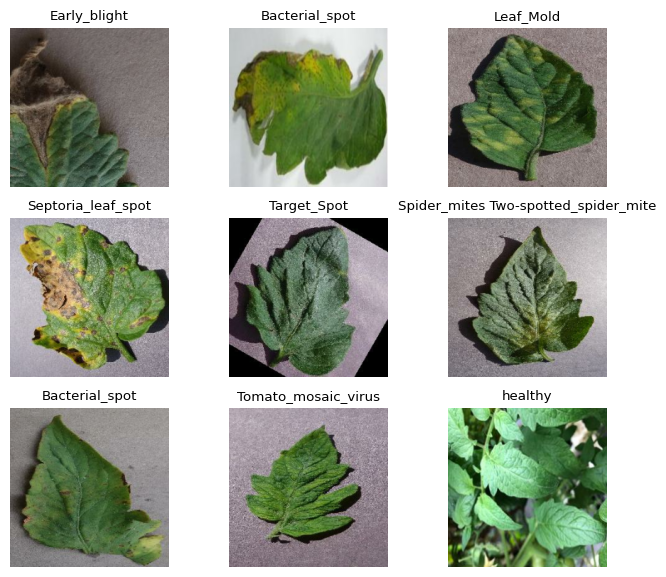

In [31]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,7))
 
for images, labels in train_ds.take(1):
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            index = np.argmax(labels[i*3+j])
            ax[i][j].set_title(train_ds.class_names[index])
            ax[i][j].axis('off')

plt.savefig(IMG_PATH+'/graph_1_original.png', dpi=DPI)
plt.show()

### Visualize Augmented Images

The preprocessing layers in Keras are specifically designed to use in the early stages of a neural network. You can use them for image preprocessing, such as to resize or rotate the image or adjust the brightness and contrast.

Below shows examples of different data augmentation techniques applied in this project:
- `tf.keras.layers.RandomFlip`
- `tf.keras.layers.RandomRotation`
- `tf.keras.layers.RandomZoom`
- `tf.keras.layers.RandomTranslation`
- `tf.keras.layers.RandomContrast`
- `tf.keras.layers.RandomBrightness`

*Reference*:
- [Image Augmentation with Keras Preprocessing Layers and tf.image](https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/)

To make model more tolerant to variations in position, we do random flipping, rotation, geometric transformation, and zooming in or zooming out original images.  

In [36]:
# create preprocessing layers to make model more robust to variations in positions
flip = layers.RandomFlip("horizontal")
rotate = layers.RandomRotation(0.1)
zoom = layers.RandomZoom(0.3)
translation = layers.RandomTranslation(height_factor=0.15, width_factor=0.15)     

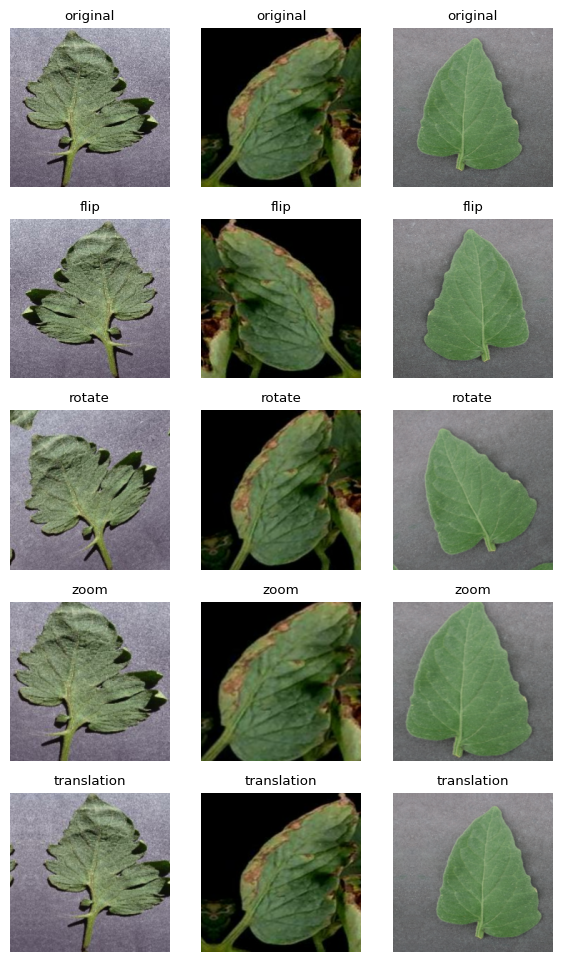

In [37]:
# visualize augmentations
fig, ax = plt.subplots(5, 3, figsize=(7,12))
 
for images, labels in train_ds.take(1):
    for i in range(3):
        # original
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        ax[0][i].axis('off')
        # flip
        ax[1][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("flip")
        ax[1][i].axis('off')
        # rotate
        ax[2][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("rotate")
        ax[2][i].axis('off')
        # zoom
        ax[3][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("zoom")
        ax[3][i].axis('off')
        # translation
        ax[4][i].imshow(translation(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("translation")
        ax[4][i].axis('off')

plt.savefig(IMG_PATH+'/graph_2_change_positions.png', dpi=DPI)
plt.show()

To make model more tolerant to different lighting conditions, we randomly adjust contrast and randomly increase/decrease brightness.

In [46]:
# create preprocessing layers to make model more robust to color and lighting
contrast = layers.RandomContrast(0.2)
brightness = layers.RandomBrightness([-0.3,0.3]) 

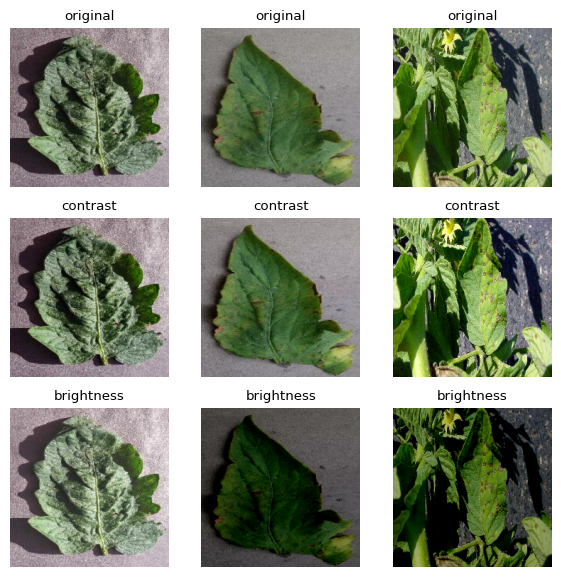

In [47]:
fig, ax = plt.subplots(3, 3, figsize=(7,7))

for images, labels in train_ds.take(1):
    for i in range(3):
        # original
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        ax[0][i].axis('off')
        # contrast
        ax[1][i].imshow(contrast(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("contrast")
        ax[1][i].axis('off')
        # brightness
        ax[2][i].imshow(brightness(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("brightness")
        ax[2][i].axis('off')

plt.savefig(IMG_PATH+'/graph_3_change_colors.png', dpi=DPI)
plt.show()

In [48]:
# save images to google drive
!cp -R $IMG_PATH /content/gdrive/MyDrive/deep_learning/graphs/data_augmentation